In [1]:
pip install pandas openpyxl scikit-learn fancyimpute

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
#load excel file
df = pd.read_excel("Cleaned_Bioreactor_Data.xlsx", engine="openpyxl")

In [3]:
#display first few rows
df.head()

,Age (Days),Biomass (µg/ml),C-Phycocyanin (µg/ml),Yield,Nitrate added (µg/ml)
0,0.000000,240.530969,4.324240,0.017978,NaN
1,0.917361,271.447278,4.779300,0.017607,1096.597856
2,1.883333,318.752372,13.333333,0.041830,1160.423633
3,4.830556,464.925403,22.496195,0.048387,1002.654289
4,5.838194,516.453257,27.001522,0.052283,1080.242500


In [4]:
from fancyimpute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import numpy as np

In [5]:
#checking for non numeric columns
print(df.dtypes)

Age (Days)               float64
Biomass (µg/ml)          float64
C-Phycocyanin (µg/ml)    float64
Yield                    float64
Nitrate added (µg/ml)    float64
dtype: object


In [6]:
#drop unnamed columns
df=df.dropna(axis=1, how="all") #remove columns that are entirely NaN
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  # Remove 'Unnamed' 
print (df.dtypes)

Age (Days)               float64
Biomass (µg/ml)          float64
C-Phycocyanin (µg/ml)    float64
Yield                    float64
Nitrate added (µg/ml)    float64
dtype: object


In [7]:
# Convert all possible numeric columns to float
df = df.apply(pd.to_numeric, errors='coerce')

# Check again if data types are now correct
print(df.dtypes)

Age (Days)               float64
Biomass (µg/ml)          float64
C-Phycocyanin (µg/ml)    float64
Yield                    float64
Nitrate added (µg/ml)    float64
dtype: object


In [8]:
#apply REGEM, filling in missing values, using iterative imputer
imputer=IterativeImputer(max_iter=10, random_state=42)
df_imputed=pd.DataFrame(imputer.fit_transform(df),columns=df.columns)
print("Data after REGEM imputation")
print(df_imputed.head())

Data after REGEM imputation
   Age (Days)  Biomass (µg/ml)  C-Phycocyanin (µg/ml)     Yield  \
0    0.000000       240.530969               4.324240  0.017978   
1    0.917361       271.447278               4.779300  0.017607   
2    1.883333       318.752372              13.333333  0.041830   
3    4.830556       464.925403              22.496195  0.048387   
4    5.838194       516.453257              27.001522  0.052283   

   Nitrate added (µg/ml)  
0            1109.191665  
1            1096.597856  
2            1160.423633  
3            1002.654289  
4            1080.242500  


In [9]:
#adding 3rd order polynomial regression to CPC, nitrate, and biomass to replicate plot in paper
#using imputed data (above) and then generating smooth curves to plot

# Biomass
biomass_df_imputed = df_imputed.dropna(subset=["Biomass (µg/ml)"]) #removes any rows that have no values, should not be bc of imputing but just in case
x_bio = biomass_df_imputed[["Age (Days)"]] # adds input x to regression
y_bio = biomass_df_imputed["Biomass (µg/ml)"] #y target number one, biomass
poly_bio = PolynomialFeatures(degree=3) #makes 3rd order polynomial 
x_bio_poly = poly_bio.fit_transform(x_bio) #Actually creates the polynomial features from time values
model_bio = LinearRegression().fit(x_bio_poly, y_bio) #trains the regression model to learn a curve that fits your biomass data over time

x_vals=df_imputed["Age (Days)"] #grabs full age column again to have range for smoothed values
x_dense = np.linspace(x_vals.min(), x_vals.max(), 200).reshape(-1, 1) #makes 200 evenly spaced time points between first and last day and gives smooth line when predicting values between them

x_dense_bio = poly_bio.transform(x_dense) #Turns smooth x-values into polynomial features
y_dense_bio = model_bio.predict(x_dense_bio)#Uses the model to predict biomass values at all the smooth time points.

# Nitrate
nitrate_df_imputed = df_imputed.dropna(subset=["Nitrate added (µg/ml)"])
x_nit = nitrate_df_imputed[["Age (Days)"]]
y_nit = nitrate_df_imputed["Nitrate added (µg/ml)"]
poly_nit = PolynomialFeatures(degree=3)
x_nit_poly = poly_nit.fit_transform(x_nit)
model_nit = LinearRegression().fit(x_nit_poly, y_nit)

x_dense_nit = poly_nit.transform(x_dense)
y_dense_nit = model_nit.predict(x_dense_nit)

# C-PC smoothing
cpc_df_imputed = df_imputed.dropna(subset=["C-Phycocyanin (µg/ml)"])
x_cpc = cpc_df_imputed[["Age (Days)"]]
y_cpc = cpc_df_imputed["C-Phycocyanin (µg/ml)"]
poly_cpc = PolynomialFeatures(degree=3)
x_cpc_poly = poly_cpc.fit_transform(x_cpc)
model_cpc = LinearRegression().fit(x_cpc_poly, y_cpc)

x_dense_cpc = poly_cpc.transform(x_dense)
y_dense_cpc = model_cpc.predict(x_dense_cpc)




/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


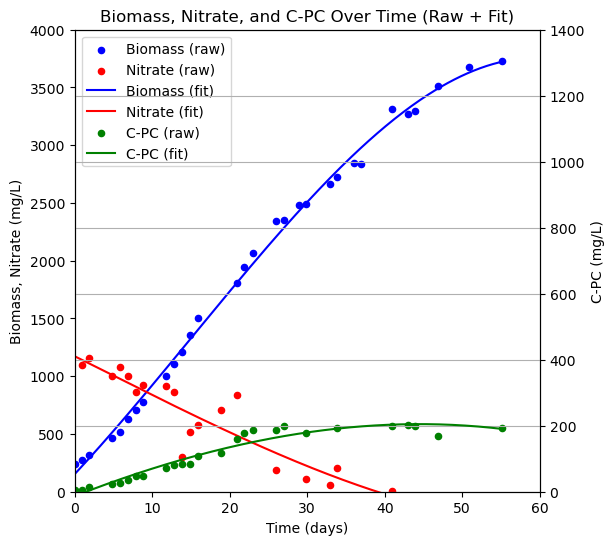

In [10]:
#plotting
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(6, 6))
x_vals = df["Age (Days)"] #grabs raw age values from original data to plot raw data


#plotting raw data for biomass and nitrate on left y-axis
ax1.scatter(x_vals, df["Biomass (µg/ml)"], color='blue', label='Biomass (raw)',s=20)
ax1.scatter(x_vals, df["Nitrate added (µg/ml)"], color='red', label='Nitrate (raw)',s=20)

#draws a smooth biomass curve using predicted values (y_dense_bio/y_dense_nitrate) over a smooth time range (x_dense) for nitrate and biomass
ax1.plot(x_dense, y_dense_bio, color='blue', label='Biomass (fit)')
ax1.plot(x_dense, y_dense_nit, color='red', label='Nitrate (fit)')

#limits and labels for primary y-axis and x-axis (limits based on paper to make look the same)
ax1.set_xlabel("Time (days)")
ax1.set_ylabel("Biomass, Nitrate (mg/L)")
ax1.set_xlim(0, 60)
ax1.set_ylim(0, 4000)

#adds CPC on right axis
ax2 = ax1.twinx() #twin function creates secondary y-axis that shares same x-axis but has different units and limits than primary y-axis
#plots raw CPC data
ax2.scatter(df["Age (Days)"], df["C-Phycocyanin (µg/ml)"], color='green', label='C-PC (raw)', s=20)
#plots smoothed fitted line over raw data
ax2.plot(x_dense, y_dense_cpc, color='green', label='C-PC (fit)')

#labels secondary y-axis and adds scale
ax2.set_ylabel("C-PC (mg/L)")
ax2.set_ylim(0, 1400)

#combines legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

#adds title
plt.title("Biomass, Nitrate, and C-PC Over Time (Raw + Fit)")
#adds gridlines
plt.grid(True)

plt.show()